In [371]:
from climada.util.api_client import Client
from climada_petals.engine import SupplyChain
from climada.entity import ImpfSetTropCyclone, ImpactFuncSet
from climada.engine.impact_calc import ImpactCalc
from climada.hazard import Hazard
import datetime
import numpy as np
client = Client()

In [ ]:
# Getting the dates we want to study

In [ ]:
from datetime import datetime

# Create a datetime object
dt_start = datetime(2012, 1, 1)
dt_end = datetime(2017, 1, 1)

# Get the proleptic Gregorian ordinal value
ordinal_value_start = dt_start.toordinal()
ordinal_value_end = dt_end.toordinal()

In [ ]:
# This cell provides the inputs for boario

In [397]:
tc_wp = client.get_hazard('tropical_cyclone', name='tropical_cyclone_0synth_tracks_150arcsec_genesis_WP_1980_2020')
tc_na = client.get_hazard('tropical_cyclone', name='tropical_cyclone_0synth_tracks_150arcsec_genesis_NA_1980_2020')
assets = client.get_litpop()

ConnectionError: HTTPSConnectionPool(host='climada.ethz.ch', port=443): Max retries exceeded with url: /data-api/v2/dataset/?data_type=tropical_cyclone&name=tropical_cyclone_0synth_tracks_150arcsec_genesis_WP_1980_2020&status=active&limit=100000 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x1fcad10a0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [586]:
haz_concat = client.get_hazard('tropical_cyclone', name='tropical_cyclone_0synth_tracks_150arcsec_global_1980_2020')


KeyboardInterrupt: 

In [680]:
# This cell provides the inputs for boario


haz_concat = Hazard.concat([tc_wp,tc_na])

def get_impf_id(cnt):
    for basin, iso_list in ImpfSetTropCyclone.get_countries_per_region()[2].items():
        for iso in iso_list:
            if iso == cnt:
                return basin, ImpfSetTropCyclone.get_countries_per_region()[1][basin]
            
impf_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

assets.gdf['impf_TC'] = 1

for cnt in np.unique(assets.gdf.region_id):
    assets.gdf.loc[assets.gdf['region_id']==cnt, 'impf_TC'] = get_impf_id(int(cnt))[1]

# impact calculation, already selecting the date
imp_calc = ImpactCalc(assets, impf_TC, haz_concat)
direct_impact = imp_calc.impact().select(dates=(ordinal_value_start,ordinal_value_end))   


supchain = SupplyChain.from_mriot(mriot_type='WIOD16', mriot_year=2011)

impacted_secs = supchain.mriot.get_sectors().tolist()

supchain.calc_secs_exp_imp_shock(assets, direct_impact, impacted_secs)
supchain.calc_direct_production_impacts()


2023-05-25 14:31:52,592 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5137781 coordinates.
2023-05-25 14:31:53,006 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 7249 coordinates.


In [667]:
quakes = client.get_hazard('earthquake', properties={"spatial_coverage":"global"})

In [681]:
supchain_impacted = supchain.dir_prod_impt_mat.loc[:, (supchain.dir_prod_impt_mat > 0).any()]
supchain_impacted = supchain_impacted.loc[(supchain_impacted > 0).any(axis=1), :]


In [682]:
impacts_by_region = supchain_impacted.groupby('region', axis=1).sum()


In [683]:
production_by_country = assets.gdf.groupby("region_id").sum().reset_index()

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_86346/2518366494.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  production_by_country = assets.gdf.groupby("region_id").sum().reset_index()


In [684]:
import pycountry
production_by_country["country_iso3"] = [pycountry.countries.lookup(format(reg_id, '03d')).alpha_3 for reg_id in production_by_country["region_id"]]

In [685]:
dates_wp = pd.DataFrame({'date':tc_wp.date,'event_id':tc_wp.event_id})
dates_na = pd.DataFrame({'date':tc_na.date,'event_id':tc_na.event_id})
dates = dates_wp.append(dates_na)


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_86346/1802810957.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dates = dates_wp.append(dates_na)


In [686]:
impacts_by_region["event_id"] = impacts_by_region.index

In [687]:
impacts_by_region = pd.merge(impacts_by_region, dates, on='event_id', how = "left")

In [688]:
impacts_by_region['year'] = [datetime.date.fromordinal(date).year for date in impacts_by_region.date]
impacts_by_region_by_years = impacts_by_region.groupby('year').sum()


In [689]:
impacts_by_region_by_years = impacts_by_region_by_years.drop(columns=["ROW", "event_id",'date'])
impacts_by_region = impacts_by_region.drop(columns=["ROW",'date', 'year'])

for col in impacts_by_region_by_years.columns:
    try:
        pycountry.countries.lookup(col)        
        impacts_by_region_by_years[col] = impacts_by_region_by_years[col]/production_by_country[production_by_country["country_iso3"]==col].value.unique()[0]
        impacts_by_region[col] = impacts_by_region[col]/production_by_country[production_by_country["country_iso3"]==col].value.unique()[0]

    except LookupError:
        continue
        

In [690]:
impacts_by_region = impacts_by_region.set_index("event_id")

In [305]:
# if we want to get 5 years
#rolling_mean_rel_impact_5y = impacts_by_region_by_years.rolling(window=5).mean().mean(axis=1)

In [698]:
impacts_by_region

,CAN,CHN,FRA,JPN,KOR,MEX,PRT,RUS,TWN,USA
event_id,,,,,,,,,,
3018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [699]:
impacts_by_region = impacts_by_region[impacts_by_region>1e-4]


In [701]:
impacts_by_region = impacts_by_region.dropna(how="all")

In [703]:
impacts_by_region.index

Int64Index([3032, 3033, 3049, 3059, 3095, 3096, 3121, 3132, 3147, 3151, 1390], dtype='int64', name='event_id')

## calculate supchain impact with only events causing damages>1e-4
(see sell above for events)

In [712]:
# This cell provides the inputs for boario


haz_concat = Hazard.concat([tc_wp,tc_na])

def get_impf_id(cnt):
    for basin, iso_list in ImpfSetTropCyclone.get_countries_per_region()[2].items():
        for iso in iso_list:
            if iso == cnt:
                return basin, ImpfSetTropCyclone.get_countries_per_region()[1][basin]
            
impf_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

assets.gdf['impf_TC'] = 1

for cnt in np.unique(assets.gdf.region_id):
    assets.gdf.loc[assets.gdf['region_id']==cnt, 'impf_TC'] = get_impf_id(int(cnt))[1]

# impact calculation, already selecting the date
haz_subset = haz_concat.select(event_id=np.array(impacts_by_region.index))

imp_calc = ImpactCalc(assets, impf_TC, haz_subset)
direct_impact = imp_calc.impact().select(dates=(ordinal_value_start,ordinal_value_end))   


supchain = SupplyChain.from_mriot(mriot_type='WIOD16', mriot_year=2011)

impacted_secs = supchain.mriot.get_sectors().tolist()

supchain.calc_secs_exp_imp_shock(assets, direct_impact, impacted_secs)
supchain.calc_direct_production_impacts()


2023-05-25 14:38:07,596 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5137781 coordinates.
2023-05-25 14:38:07,984 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 7249 coordinates.


In [693]:
impacts_by_region_by_years = impacts_by_region_by_years[impacts_by_region_by_years>1e-3]


In [694]:
impacts_by_region_by_years.dropna(how="all").fillna(0)

,CAN,CHN,FRA,JPN,KOR,MEX,PRT,RUS,TWN,USA
year,,,,,,,,,,
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001996
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001365,0.000000
2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001326,0.000000
2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001045,0.000000


In [695]:
import copy
impacts_by_region_by_years_binary = copy.deepcopy(impacts_by_region_by_years)

In [696]:
impacts_by_region_by_years_binary = impacts_by_region_by_years_binary>1e-3


In [303]:
rolling_mean_ncountries_5y = impacts_by_region_by_years_binary.rolling(window=5).sum().sum(axis=1)

In [300]:
def normalize_series(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

In [306]:
rolling_mean_ncountries_5y = normalize_series(rolling_mean_ncountries_5y)
rolling_mean_rel_impact_5y = normalize_series(rolling_mean_rel_impact_5y)

In [335]:
(rolling_mean_rel_impact_5y+rolling_mean_ncountries_5y).idxmax()

1998

In [349]:
from datetime import datetime

# Create a datetime object
dt_start = datetime(2012, 1, 1)
dt_end = datetime(2017, 1, 1)

# Get the proleptic Gregorian ordinal value
ordinal_value_start = dt_start.toordinal()
ordinal_value_end = dt_end.toordinal()


In [351]:
ordinal_value_end

736330

In [339]:
(rolling_mean_rel_impact_5y+rolling_mean_ncountries_5y).sort_values(ascending=False)

year
1998    1.937500
2017    1.841243
1997    1.840993
2000    1.808039
1994    1.759149
2008    1.710399
1996    1.694779
2012    1.688950
2011    1.684069
2018    1.670143
2009    1.657504
2010    1.601042
2016    1.600024
1999    1.523996
2019    1.513391
2015    1.423282
1990    1.335353
1993    1.307293
1991    1.247323
2013    1.233385
1992    1.218813
2001    1.211861
2020    1.209157
1995    1.190694
2014    1.190612
2004    1.006045
1989    1.001927
2007    0.996839
1987    0.986057
1986    0.980155
1988    0.953122
2002    0.905339
2003    0.875000
1984    0.872199
2005    0.852464
2006    0.770690
1985    0.725971
1980         NaN
1981         NaN
1982         NaN
1983         NaN
dtype: float64

In [342]:
rolling_mean_ncountries_5y.sort_values(ascending=False)

year
2000    1.0000
2016    1.0000
2001    1.0000
1998    0.9375
1994    0.9375
1997    0.9375
2018    0.9375
2017    0.9375
2015    0.8750
1996    0.8750
2007    0.8750
2004    0.8750
2003    0.8750
1999    0.8750
2014    0.8750
2013    0.8750
1995    0.8750
1993    0.8750
1990    0.8750
1989    0.8750
2012    0.8125
2010    0.8125
2009    0.8125
2008    0.8125
1988    0.8125
2005    0.8125
2002    0.8125
2019    0.8125
1987    0.8125
1991    0.8125
1992    0.8125
2006    0.7500
2011    0.7500
1986    0.7500
2020    0.6875
1985    0.6250
1984    0.6250
1981    0.0000
1983    0.0000
1982    0.0000
1980    0.0000
dtype: float64

In [341]:
rolling_mean_rel_impact_5y.sort_values(ascending=False)

year
1998    1.000000
2011    0.934069
2017    0.903743
1997    0.903493
2008    0.897899
2012    0.876450
2009    0.845004
1994    0.821649
1996    0.819779
2000    0.808039
2010    0.788542
2018    0.732643
2019    0.700891
1999    0.648996
2016    0.600024
2015    0.548282
2020    0.521657
1990    0.460353
1991    0.434823
1993    0.432293
1992    0.406313
2013    0.358385
1995    0.315694
2014    0.315612
1984    0.247199
1986    0.230155
2001    0.211861
1987    0.173557
1988    0.140622
2004    0.131045
1989    0.126927
2007    0.121839
1985    0.100971
2002    0.092839
2005    0.039964
2006    0.020690
2003    0.000000
1980         NaN
1981         NaN
1982         NaN
1983         NaN
dtype: float64

In [336]:
rolling_mean_rel_impact_5y.idxmax()

1998

In [338]:
rolling_mean_ncountries_5y.idxmax()

2000

In [329]:
impacts_by_region_by_years_binary.sum(axis=1)

year
1980    3
1981    2
1982    2
1983    1
1984    2
1985    3
1986    4
1987    3
1988    1
1989    3
1990    3
1991    3
1992    3
1993    2
1994    4
1995    2
1996    3
1997    4
1998    2
1999    3
2000    4
2001    3
2002    1
2003    3
2004    3
2005    3
2006    2
2007    3
2008    2
2009    3
2010    3
2011    1
2012    4
2013    3
2014    3
2015    3
2016    3
2017    3
2018    3
2019    1
2020    1
dtype: int64

<Axes: xlabel='year'>

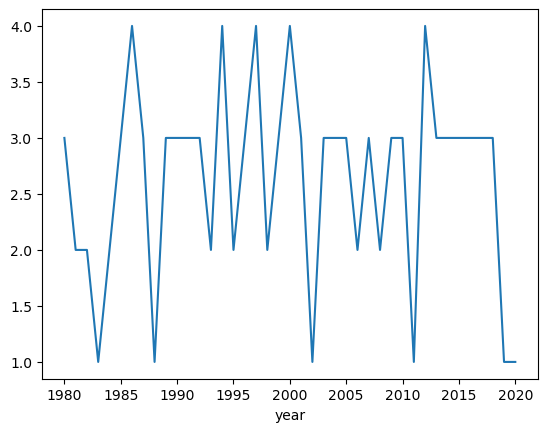

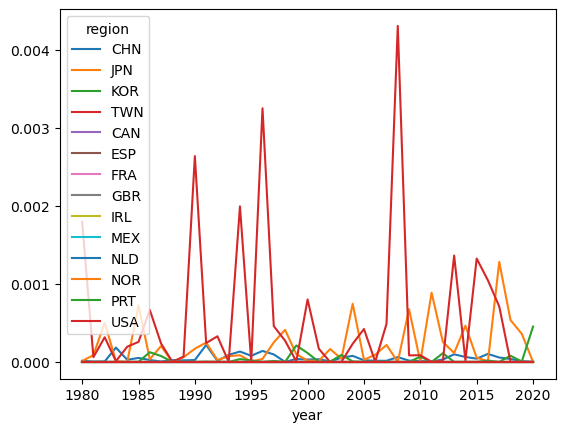

In [328]:
impacts_by_region_by_years_binary.sum(axis=1).plot()
impacts_by_region_by_years.drop(["IND","RUS"], axis=1).plot()

In [ ]:
#number of countries affected by damages over 0.1%?

<GeoAxes: title={'center': 'Event ID 3187: 2017288N09138'}>

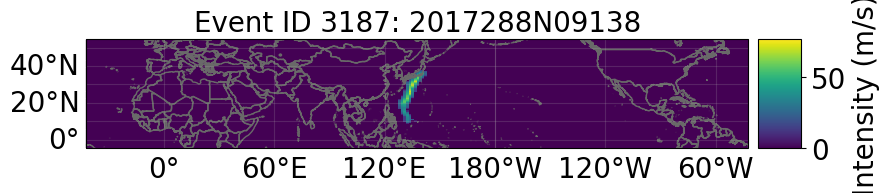

In [15]:
tc_wp.plot_intensity(supchain_impacted.sum(axis=1).idxmax())

In [16]:
supchain_impacted.to_csv("1980_2020_wp_secs_exp_imp_shock.csv")